Here, we use a simple set-up of a short piece of casing with a current source aligned along its axis. We solve in 3D and using the cyl symmetric soln and compare. 

In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import sympy
import matplotlib.pyplot as plt
from scipy.constants import mu_0

from SimPEG.EM import FDEM
from SimPEG import Utils, Maps

from pymatsolver import Pardiso

%matplotlib inline

In [2]:
import sys

In [3]:
import CasingSimulations

In [4]:
# Simulation Parameters 
# In this example, we will use a wholespace

In [5]:
sigma_back = 1e-1 # wholespace

cp = CasingSimulations.CasingProperties(
    casing_l = 10.,
    src_a = np.r_[0., 0., -9.],
    src_b = np.r_[0., 0., -1.],
    freqs = np.r_[0.1, 1., 2.],
    sigma_back = sigma_back, # wholespace
    sigma_layer = sigma_back,
    sigma_air = sigma_back,
    
)
cp.serialize()

{u'__class__': 'CasingProperties',
 'casing_d': 0.1,
 'casing_l': 10.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'freqs': [0.1, 1.0, 2.0],
 'layer_z': [-1000.0, -900.0],
 'mu_casing': 100.0,
 'sigma_air': 0.1,
 'sigma_back': 0.1,
 'sigma_casing': 5500000.0,
 'sigma_inside': 1.0,
 'sigma_layer': 0.1,
 'src_a': [0.0, 0.0, -9.0],
 'src_b': [0.0, 0.0, -1.0]}

In [6]:
npadx, npadz = 11, 26
dx2 = 500. 

mesh2D = CasingSimulations.CasingMesh(cp=cp, npadx=npadx, npadz=npadz, dx2=dx2).mesh
mesh3D = CasingSimulations.CasingMesh(cp=cp, ncy=4, npadx=npadx, npadz=npadz, dx2=dx2).mesh

In [7]:
print(mesh2D.nC, mesh3D.nC)

(23580, 94320)


In [8]:
print('skin depth: {}'.format(500/np.sqrt(sigma_back * cp.freqs.min())))

skin depth: 5000.0


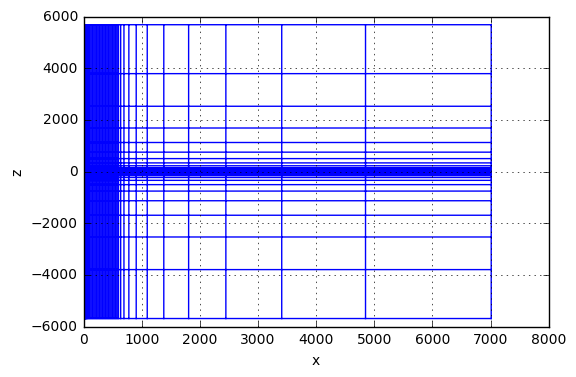

In [9]:
mesh2D.plotGrid()

In [10]:
def getSrcWire(mesh):
    wire = np.zeros(mesh.vnF[2])

    xfaces = mesh.gridFz[:,0] < mesh.hx.min()
    zfaces = (mesh.gridFz[:,2] > cp.src_a[2]) & (mesh.gridFz[:,2] < cp.src_b[2])
    wire[xfaces & zfaces] = 1
    
    return np.hstack([np.zeros(mesh.nFx), np.zeros(mesh.nFy), wire]) 

In [11]:
# specify current density on the faces (wire source through center of well) - 2D mesh
wire2D = getSrcWire(mesh2D)
wire3D = getSrcWire(mesh3D)

In [12]:
srcList2D = [FDEM.Src.RawVec_e(s_e=wire2D, freq=freq, rxList=[]) for freq in cp.freqs]
srcList3D = [FDEM.Src.RawVec_e(s_e=wire3D, freq=freq, rxList=[]) for freq in cp.freqs] 

In [13]:
def getPhysProps(mesh):
    
    casing_x = (mesh.gridCC[:,0] > cp.casing_a) & (mesh.gridCC[:,0] < cp.casing_b)
    casing_z = (mesh.gridCC[:,2] > cp.casing_z[0]) & (mesh.gridCC[:,2] < cp.casing_z[1])
    
    inside_x = (mesh.gridCC[:,0] < cp.casing_a)
    
    sigma = cp.sigma_back * np.ones(mesh.nC)
    sigma[casing_x & casing_z] = cp.sigma_casing
    sigma[inside_x & casing_z] = cp.sigma_inside
    
    mu = np.ones(mesh.nC)
    mu[casing_x & casing_z] = cp.mu_casing
    mu = mu * mu_0
    
    return sigma, mu
    
sigma2D, mu2D = getPhysProps(mesh2D)
sigma3D, mu3D = getPhysProps(mesh3D)

(-20.0, 10.0)

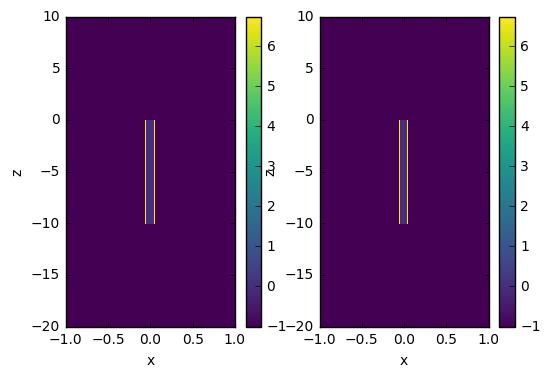

In [14]:
fig, ax = plt.subplots(1, 2)
plt.colorbar(
    mesh2D.plotImage(np.log10(sigma2D), ax=ax[0], mirror=True)[0], ax=ax[0]
)
ax[0].set_xlim([-1., 1.])
ax[0].set_ylim([-20., 10.])

sigmaplt = sigma3D.reshape(mesh3D.vnC, order='F')

plt.colorbar(mesh2D.plotImage(np.log10(utils.mkvc(sigmaplt[:,0,:])), ax=ax[1], mirror=True)[0], ax=ax[1])
ax[1].set_xlim([-1., 1.])
ax[1].set_ylim([-20., 10.])

(-20.0, 10.0)

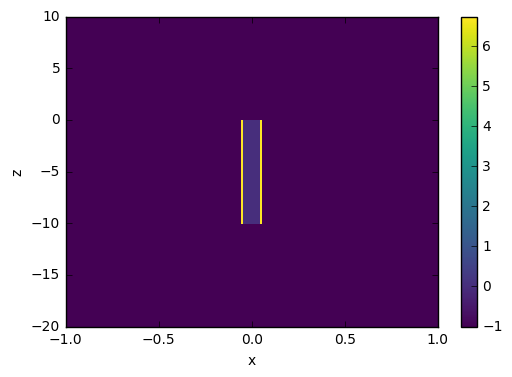

In [15]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(mesh2D.plotImage(np.log10(utils.mkvc(sigmaplt[:,0,:])), ax=ax, mirror=True)[0], ax=ax)
ax.set_xlim([-1., 1.])
ax.set_ylim([-20., 10.])

In [16]:
wires2D = Maps.Wires(('sigma', mesh2D.nC), ('mu', mesh2D.nC))
wires3D = Maps.Wires(('sigma', mesh3D.nC), ('mu', mesh3D.nC))

In [17]:
prb2D = FDEM.Problem3D_h(mesh2D, sigmaMap=wires2D.sigma, muMap=wires2D.mu, Solver=Pardiso)
prb3D = FDEM.Problem3D_h(mesh3D, sigmaMap=wires3D.sigma, muMap=wires3D.mu, Solver=Pardiso)

In [18]:
survey2D = FDEM.Survey(srcList2D)
survey3D = FDEM.Survey(srcList3D)

In [19]:
prb2D.pair(survey2D)
prb3D.pair(survey3D)

In [20]:
%%time

fields2D = prb2D.fields(np.hstack([sigma2D, mu2D]))

CPU times: user 962 ms, sys: 96.4 ms, total: 1.06 s
Wall time: 795 ms


In [21]:
%%time

fields3D = prb3D.fields(np.hstack([sigma3D, mu3D]))

CPU times: user 1min 24s, sys: 6.52 s, total: 1min 30s
Wall time: 1min 6s


In [22]:
freqind = 0
print('getting j at {}Hz'.format(cp.freqs[freqind]))

j2D = fields2D[srcList2D[0], 'j']
j3D = fields3D[srcList3D[0], 'j']

getting j at 0.1Hz


In [23]:
from matplotlib.colors import LogNorm


In [24]:
def getj3Dplot(j3D, theta_ind=0):
    j3D_x = j3D[:mesh3D.nFx].reshape(mesh3D.vnFx, order='F')
    j3D_z = j3D[mesh3D.vnF[:2].sum():].reshape(mesh3D.vnFz, order='F')
    
    j3Dplt = np.vstack([utils.mkvc(j3D_x[:,theta_ind,:],2), utils.mkvc(j3D_z[:,theta_ind,:],2)])
    
    return j3Dplt
    
    
j3Dplt = getj3Dplot(j3D,1)

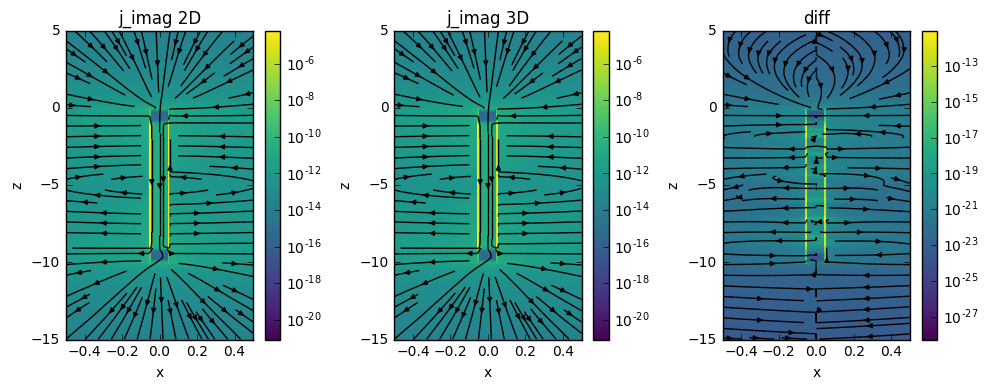

In [25]:
fig, ax = plt.subplots(1,3, figsize=(10, 4))
plt.colorbar(
    mesh2D.plotImage(
        j3Dplt.imag, view='vec', vType='F', ax=ax[0], range_x=np.r_[-0.5, 0.5], range_y=np.r_[-15., 5.], mirror=True, 
        pcolorOpts={
            'norm':LogNorm(), 'cmap': plt.get_cmap('viridis')
        },
    )[0], ax=ax[0]
)

plt.colorbar(
    mesh2D.plotImage(
        j2D.imag, view='vec', vType='F', ax=ax[1], range_x=np.r_[-0.5, 0.5], range_y=np.r_[-15., 5.], mirror=True, 
        pcolorOpts={
            'norm':LogNorm(), 'cmap': plt.get_cmap('viridis')
        },
    )[0], ax=ax[1]
)


plt.colorbar(
    mesh2D.plotImage(
        (j3Dplt - j2D).imag, view='vec', vType='F', ax=ax[2], range_x=np.r_[-0.5, 0.5], range_y=np.r_[-15., 5.], mirror=True, 
         pcolorOpts={'norm':LogNorm(), 'cmap': plt.get_cmap('viridis')
        },
    )[0], ax=ax[2]
)

ax[0].set_title('j_imag 2D')
ax[1].set_title('j_imag 3D')
ax[2].set_title('diff')


plt.tight_layout()

In [26]:
j2D = fields2D[srcList2D[0], 'j']
j3D = fields3D[srcList3D[0], 'j']

In [27]:
h2D = fields2D[srcList2D[0], 'h']
h3D = fields3D[srcList3D[0], 'h']

In [34]:
def geth3Dthetaslice( h3D, theta_ind=0):    
    h3D_y = h3D[mesh3D.vnE[0]:mesh3D.vnE[:2].sum()].reshape(
        mesh3D.vnEy, order='F'
    )

    return utils.mkvc(h3D_y[:, theta_ind, :], 2)

In [35]:
src = srcList3D[0]

In [36]:
h3D = fields3D[src, 'h']
h0 = geth3Dthetaslice(h3D)

In [38]:
np.linalg.norm(h0)

0.01995458514557032

In [40]:
h0.shape

(23670, 1)

In [42]:
mesh3D.nEy/4

23670

In [44]:
h1 = geth3Dthetaslice(h3D, 1)

In [45]:
np.linalg.norm(h1)

0.019954585166911148

In [51]:
np.linalg.norm(h1-h0)/np.linalg.norm(h0)

6.163456752295841e-05

In [68]:
h3D = fields3D[src, 'h']
hr = h3D[:mesh3D.nEx]
hz = h3D[mesh3D.vnE[:2].sum():]

In [78]:
(hr > 1e-7).sum()

0

In [79]:
hr.max()

(5.5579992813133342e-10-5.6853698298066233e-08j)

In [77]:
np.absolute(hz).max()

2.628571173876622e-08